## Installations + Import Libraries

In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 41.6 MB/s eta 0:00:00


In [ ]:
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from sklearn.model_selection import train_test_split

## Load Data + Helper Data Methods

In [3]:
# BINDING AFFINITIES DATASET.

column_names = ["PDB code", "resolution", "release year", "-logKd/Ki", "Kd/Ki", "comment", "reference", "ligand name"]

data = pd.read_csv('INDEX_refined_data.2020', sep='\s+', comment='#', header=None, names=column_names)
data = data.drop(["release year", "comment", "reference"], axis=1)
print(data.head(15))

   PDB code  resolution  -logKd/Ki      Kd/Ki ligand name
0      2r58        2.00       2.00    Kd=10mM       (MLY)
1      3c2f        2.35       2.00  Kd=10.1mM       (PRP)
2      3g2y        1.31       2.00    Ki=10mM       (GF4)
3      3pce        2.06       2.00    Ki=10mM       (3HP)
4      4qsu        1.90       2.00    Kd=10mM       (TDR)
5      4qsv        1.90       2.00    Kd=10mM       (THM)
6      4u54        2.41       2.06   Kd=8.7mM       (3C5)
7      3ao4        1.95       2.07   Kd=8.5mM       (833)
8      4cs9        2.01       2.10     Kd=8mM       (AMP)
9      2w8w        2.14       2.12   Kd=7.5mM       (PLS)
10     3gv9        1.80       2.12   Ki=7.5mM       (GV9)
11     6r9u        1.26       2.12   Kd=7.5mM       (JVQ)
12     6abx        1.70       2.14  Ki=7.19mM       (FLC)
13     4q90        1.54       2.15   Ki=7.0mM       (4H2)
14     5cs3        2.50       2.15   Kd=7.0mM       (EP1)


In [5]:
# Get number of SMILES-protein pairs.
def count_lines_in_file(filename):
    with open(filename, 'r') as f:
        return sum(1 for line in f)

# Get the number of unique SMILES/proteins.
def count_unique_lines_in_file(filename):
    unique_lines = set()
    with open(filename, 'r') as f:
        for line in f:
            unique_lines.add(line.strip())
    return len(unique_lines)

# List of .smi files.
smi_files = ["smiles.smi", "uniprot_ID.smi"]

for file in smi_files:
    print(f"{file}: {count_lines_in_file(file)} lines")
    print(f"{file}: {count_unique_lines_in_file(file)} unique lines")


smiles.smi: 551223 lines
smiles.smi: 333399 unique lines
uniprot_ID.smi: 551223 lines
uniprot_ID.smi: 1970 unique lines


In [ ]:
# Helper function to get affinity based on PDB Code.
def get_affinity(code):
  find = data.loc[data['PDB code'] == code]
  return find['-logKd/Ki'].values[0]

In [ ]:
# Calculate one-hot encodings for featurization, some modifications from original paper.

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    #print list((map(lambda s: x == s, allowable_set)))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_feature(m, atom_i, i_donor, i_acceptor):

    atom = m.GetAtomWithIdx(atom_i)
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'B', 'H']) +
                    one_of_k_encoding_unk(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (10, 6, 5, 6, 1) --> total 28

In [ ]:
# Calculate the actual atom features.

def get_atom_feature(mol, is_ligand):
    H = []
    for i in range(mol.GetNumAtoms()):
        H.append(atom_feature(mol, i, None, None))
    H = np.array(H)
    if is_ligand:
        H = np.concatenate([H, np.zeros((H.shape[0], 28))], axis=1)
    else:
        H = np.concatenate([np.zeros((H.shape[0], 28)), H], axis=1)
    return H

In [ ]:
# Convert a protein-ligand pair into graph + distance representations. See paper for details.

def preprocess(lig, prot):

  try:
    # Compute adjacency matrices.
    lig_adj = GetAdjacencyMatrix(lig) + np.eye(lig.GetNumAtoms())
    prot_adj = GetAdjacencyMatrix(prot) + np.eye(prot.GetNumAtoms())

  # Compute 3D -xyz coordinates.
    lig1 = lig.GetConformers()[0]
    prot1 = prot.GetConformers()[0]
    lig_pos = np.array(lig1.GetPositions())
    prot_pos = np.array(prot1.GetPositions())
  except:
    return None, None, None

  # Compute distance matrix.
  dm = distance_matrix(lig_pos, prot_pos)

  # Get all the protein atoms that are within 8Å of any ligand atom.
  mask = (dm <= 8).any(axis=0)

  # Use mask to filter protein atoms and adjacency matrix:
  prot_pos_filtered = prot_pos[mask]
  prot_adj_filtered = prot_adj[mask][:, mask]

  # Create A1: the original adjacency matrices aggregated together.
  # Ligand on the top left, protein on the bottom right. Everywhere else, 0.
  n1 = lig.GetNumAtoms()
  n2 = prot_pos_filtered.shape[0]
  agg_adj1 = np.zeros((n1 + n2, n1 + n2))
  agg_adj1[:n1, :n1] = lig_adj
  agg_adj1[n1:, n1:] = prot_adj_filtered

  # Create A2: A1, but now with force estimation equation for ligand-protein atoms within 5Å of each other.
  new_dm = distance_matrix(lig_pos, prot_pos_filtered)

  # Define initial u and sigma parameters.
  u = 1.0
  sigma = 1.0

  # Calculate e^-(dij-u)^2/sigma for dij < 5Å.
  dm_exp = np.exp(-(np.square(new_dm - u)) / sigma)

  # Create a mask where the distance is less than 5Å.
  mask = np.where(new_dm < 5.0, 1, 0)

  # Copy adjacency matrix A1 to A2.
  agg_adj2 = np.copy(agg_adj1)

  # Add calculated values to A2 where one atom is from protein and the other is from ligand.
  agg_adj2[:n1, n1:] = dm_exp * mask
  agg_adj2[n1:, :n1] = (dm_exp * mask).T

  mask = (dm < 8).any(axis=0)

  # Obtain atom features for the ligand.
  H_ligand = get_atom_feature(lig, is_ligand=True)

  # Obtain atom features for the protein.
  H_protein = get_atom_feature(prot, is_ligand=False)
  H_protein_filtered = H_protein[mask]

  # Featurized vector (N atoms x 56 features).
  H = np.concatenate([H_ligand, H_protein_filtered], 0)

  return agg_adj1, agg_adj2, H

In [ ]:
# Create the dataset, which in this case is truncated to the first 100 examples, given long loading time.

def create_dataset():
  dir_path = "drive/MyDrive/refined-set"
  counter = 0

  dataset = []

  for code in os.listdir(dir_path):
    if counter >= 100:
      break

    try:
      affinity = get_affinity(code)
    except:
      continue

    counter += 1

    pdb_dir = os.path.join(dir_path, code)

    try:
      ligand_file = os.path.join(pdb_dir, f'{code}_ligand.mol2')
      ligand = Chem.MolFromMol2File(ligand_file)
      protein_file = os.path.join(pdb_dir, f'{code}_protein.pdb')
      protein = Chem.MolFromPDBFile(protein_file)
    except:
      continue

    a1, a2, x = preprocess(ligand, protein)
    if a1 is None:
      continue

    data_dict = {'x': x, 'a1': a1, 'a2': a2, 'affinity': affinity}

    dataset.append(data_dict)

  return dataset

In [ ]:
w = create_dataset()

[05:49:43] Explicit valence for atom # 5911 O, 3, is greater than permitted


## Model Layers + Architecture

In [ ]:
# DISTANCE-AWARE GRAPH ATTENTION MECHANISM.

class GAT_gate(torch.nn.Module):
    def __init__(self, n_in_feature, n_out_feature):
        super(GAT_gate, self).__init__()
        self.W = nn.Linear(n_in_feature, n_out_feature)
        self.A = nn.Parameter(torch.zeros(size=(n_out_feature, n_out_feature)))
        self.gate = nn.Linear(n_out_feature*2, 1)
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, x, adj):
        h = self.W(x)
        batch_size = h.size()[0]
        N = h.size()[1]
        # Obtain attention coefficients.
        e = torch.einsum('ijl,ikl->ijk', (torch.matmul(h,self.A), h))
        e = e + e.permute((0,2,1))
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        # Normalize attention coefficients.
        attention = F.softmax(attention, dim=1)
        attention = attention*adj
        h_prime = F.relu(torch.einsum('aij,ajk->aik',(attention, h)))
        # Gate mechanism.
        coeff = torch.sigmoid(self.gate(torch.cat([h,h_prime], -1)))
        retval = coeff*h+(1-coeff)*h_prime
        return retval

In [ ]:
# NEURAL NETWORK ARCHITECTURE.

class GAT_Net(torch.nn.Module):
  def __init__(self, n_features, n_output, n_layers, hidden_dim):
    super(GAT_Net, self).__init__()
    self.gat_layers = self.build_gat_layers(n_layers, n_features, hidden_dim)
    self.mlp = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, n_output))

  def build_gat_layers(self, n_layers, n_features, hidden_dim):
    gat_layers = nn.ModuleList()
    input_dim = n_features
    for _ in range(n_layers):
      gat_layers.append(GAT_gate(input_dim, hidden_dim))
      input_dim = hidden_dim
    return gat_layers

  def forward(self, x, a1, a2):
    x1 = x2 = x
    # Produce two new node features.
    for gat_layer in self.gat_layers:
      x1 = gat_layer(x1, a1)
      x2 = gat_layer(x2, a2)
    # Learn the difference between structure in a binding pose, and structure as separated.
    x_out = x2-x1

    L = x_out.shape[1] // 2
    # Vector representing protein-ligand graph complex.
    x_graph = x_out[:, :L, :].sum(1)

    return self.mlp(x_graph)

## Model Dataset Preprocessing + Training

In [ ]:
# Create DataLoader for training and validation set.
def create_data_loader(dataset, batch_size, shuffle=True):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    return data_loader

In [ ]:
# Collate function to pad data from different shapes.

def collate_fn(batch):
    # Determines the maximum number of atoms across all graphs in the batch.
    max_natoms = max([item['x'].shape[0] for item in batch])

    # Pre-allocate numpy arrays for the batch of node features 'x', adjacency matrices 'a1', 'a2', and affinity values.
    x_batch = np.zeros((len(batch), max_natoms, n_features)) # n_features is 56
    a1_batch = np.zeros((len(batch), max_natoms, max_natoms))
    a2_batch = np.zeros((len(batch), max_natoms, max_natoms))
    affinity_batch = np.zeros((len(batch),))

    # Fill the pre-allocated arrays with the respective data from each graph.
    for i, item in enumerate(batch):
        natom = item['x'].shape[0]

        x_batch[i,:natom] = item['x']
        a1_batch[i,:natom,:natom] = item['a1']
        a2_batch[i,:natom,:natom] = item['a2']
        affinity_batch[i] = item['affinity']

    # Convert the numpy arrays to PyTorch tensors.
    x_batch = torch.from_numpy(x_batch).float()
    a1_batch = torch.from_numpy(a1_batch).float()
    a2_batch = torch.from_numpy(a2_batch).float()
    affinity_batch = torch.from_numpy(affinity_batch).float()

    # Return the batch of data.
    return x_batch, a1_batch, a2_batch, affinity_batch



In [ ]:
# Define hyperparameters.
batch_size = 16
learning_rate = .001
num_epochs = 300

# Create data loaders.
train_data, val_data = train_test_split(w, test_size = 0.2)
train_loader = create_data_loader(train_data, batch_size)
val_loader = create_data_loader(val_data, batch_size)

# Initialize model.
n_features = 56 # Dimension of atom feature vectors.
n_output = 1 # Predicting a scalar binding affinity value.
n_layers = 3 # Number of GAT layers.
hidden_dim = 64 # Hidden dimension.

model = GAT_Net(n_features, n_output, n_layers, hidden_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = torch.nn.MSELoss().to(device)

# Define loss function and optimizer.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, train_dataloader, val_dataloader, num_epochs, optimizer, loss_fn, device):
    model.train()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            x, a1, a2, affinity = [item.to(device) for item in data]
            optimizer.zero_grad()
            outputs = model(x, a1, a2).squeeze()
            loss = loss_fn(outputs, affinity)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validate.
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, val_data in enumerate(val_dataloader):
                x, a1, a2, affinity = [item.to(device) for item in val_data]
                val_outputs = model(x, a1, a2).squeeze()
                val_loss = loss_fn(val_outputs, affinity)
                running_val_loss += val_loss.item()
            avg_val_loss = running_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)

        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}] training loss: {avg_train_loss}, validation loss: {avg_val_loss}')

    return train_losses, val_losses


torch.save(model.state_dict(), 'DTI_weights.pth')

Epoch [1/300] training loss: 41.46357955932617, validation loss: 58.41362380981445
Epoch [2/300] training loss: 41.07606658935547, validation loss: 53.52853775024414
Epoch [3/300] training loss: 40.792694091796875, validation loss: 54.74659729003906
Epoch [4/300] training loss: 40.585611724853514, validation loss: 52.271018981933594
Epoch [5/300] training loss: 40.248095703125, validation loss: 48.80052947998047
Epoch [6/300] training loss: 39.84027862548828, validation loss: 47.53629112243652
Epoch [7/300] training loss: 39.50729751586914, validation loss: 51.50333023071289
Epoch [8/300] training loss: 39.21646347045898, validation loss: 48.09067916870117
Epoch [9/300] training loss: 38.76084213256836, validation loss: 57.658260345458984
Epoch [10/300] training loss: 38.36202545166016, validation loss: 51.04512596130371
Epoch [11/300] training loss: 38.01826171875, validation loss: 46.19978141784668
Epoch [12/300] training loss: 37.62956161499024, validation loss: 48.72515296936035
Ep

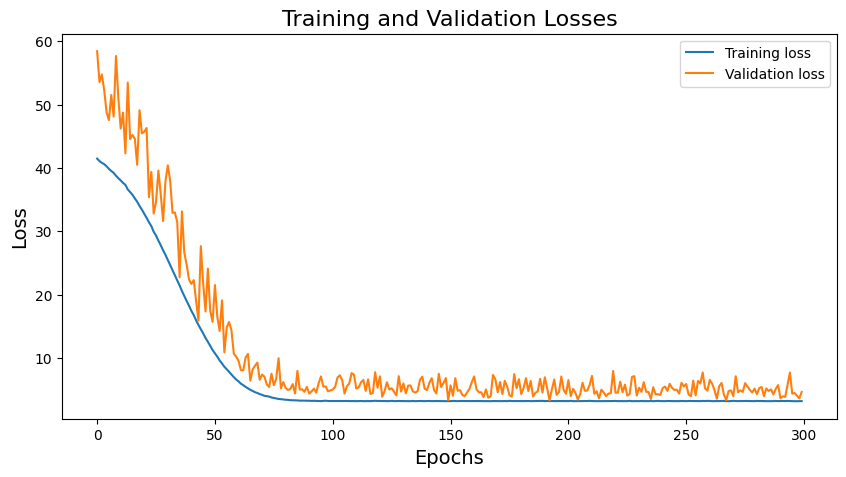

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, num_epochs, optimizer, loss_fn, device)

# Plotting.
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Losses', fontsize=16)
plt.legend()
plt.show()


To be continued . . .